In [2]:
import networkx as nx
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
#from karateclub import Node2Vec
from src.helper import draw_spring, load_graph_from_json, dataframe_from_results
np.random.seed(123)

# 4 Community Detection

Networks can be highly complex, often spanning hundreds, thousands, or even millions of nodes. One way of identifying possible patterns within such complexity is grouping nodes together in clusters or communities. Depending on the domain, theme, or topic being researched, clustering nodes can reveal actors that interact more closely with each other, documents that are more similar to each other, or precedents that frequently cite each other.

Consider a citation network of 20,000 cases. Community detection might allow finding cases that focus on the same legal problem, such as causation, fair trial, or duty of care. Once such communities are identified, centrality measures can reveal the most important cases for each grouping. Or perhaps one finds it useful to search for sub-communities within a chosen grouping. And adding a temporal dimension to the analysis might reveal how the law developed over time, with some groupings forming or unraveling as the jurisprudence develops.

Communities can be visible to the naked eye, as we can see here with an example of the barbell graph. This is a form of graph with two obvious communities in the "plates" of the barbell that are joined together by a number of nodes that form the metal shaft.

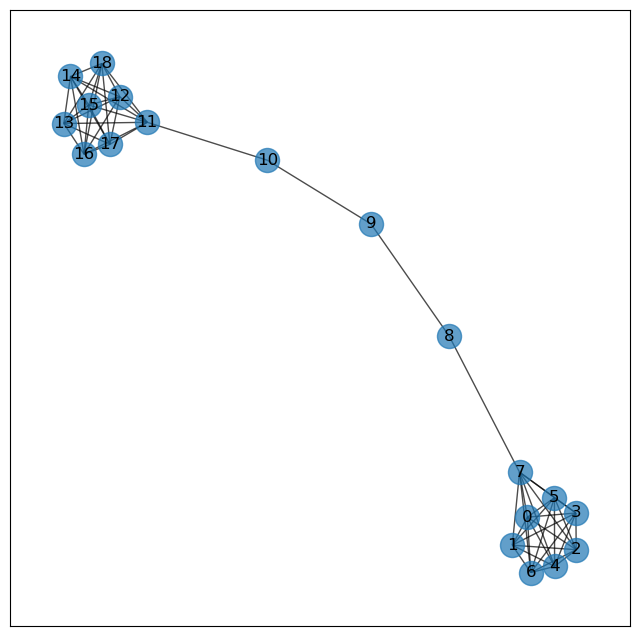

In [3]:
g_barbell = nx.barbell_graph(8, 3)
draw_spring(g_barbell)

In real world networks it is unlikely that it will be possible to identify communities just by looking. This is when community detection algorithms can aid the analysis. "Aid", because domain expertise is required to choose which network algorithm to use, and to determine whether the communities identified are substantively meaningful. 

In this chapter we will present three community detection algorithms: the Girvan-Newman algorithm, Label Propagation Communities, and Louvain Communities. Other algorithms exist, but are not covered in this work.

## 4.1 Girvan-Newman

The Girvan-Newman method for partitioning of communities (Girvan and Newman, 2002) depends on the edge-betweenness property. We have covered node-betweenness in Chapter 3. Node-betweennes measures how many shortest paths between nodes $v$ and $w$ pass through a given node $n$. Edge-betweenness measures the same property, but for edges instead of nodes. The notation is as follows:

$$ \beta(e) = \sum_{s, t \in V} \frac{\sigma(s, t | e)}{ \sigma(s, t)} $$

Where $\beta(e)$ denotes the betweenness score for edge $e$, and $ \sigma $ is a letter chosen to denote the shortest path function. Then $\frac{\sigma(s, t | e)}{ \sigma(s, t)} $ is read as referring to the shortest paths between nodes $s$ and $t$ that pass through edge $e$, and the total number of shortest paths between $s$ and $t$. This operation is summed over every $s$, $t$ that belong to the set $V$ (that is, $\sum_{s, t \in V}$), which are nodes for which a shortest path between $s$ and $t$ is to be found. In edge-betweeenness centrality, this score can be normalized by multiplying it by $ 2 / (n(n-1) $. 

In practice, we can calculate edge-betweenness using the edge_betweenness_centrality function in NetworkX. This will provide a list of all the edges present in the network with their centrality score, as we can see below:

In [4]:
g_karate = nx.karate_club_graph()
edges = nx.edge_betweenness_centrality(g_karate).keys()
scores = nx.edge_betweenness_centrality(g_karate).values()
pd.DataFrame({"edges":edges, "scores":scores}).sort_values("scores", ascending=False).set_index("edges")

,scores
edges,
"(0, 31)",0.127260
"(0, 6)",0.078134
"(0, 5)",0.078134
"(0, 2)",0.077788
"(0, 8)",0.074240
...,...
"(26, 29)",0.004533
"(24, 25)",0.004219
"(3, 7)",0.003366


The Girvan-Newman algorithm progressively removes the edge with the highest betweenness centrality score. This will eventually break down the graph, creating distinct disconnected components that will function as communities. In every new iteration in the process, the betweenness centrality for edges is recalculated. The calculation becomes progressively easier as more and more edges are removed.

In NetworkX this is impemented as an iterator, which can be run multiple times using the next() function. Running next() on the iterator will return the connected components of the graph as long as there is a reduction in the number of connected components. 

The results are shown below:

In [5]:
gn_iterator = nx.algorithms.community.girvan_newman(g_karate)

gn_communities = []
for i in range(0,5):
    temp = next(gn_iterator)
    print(f"iteration {i} with {i+2} connected components")
    print(temp)
    print("\n")
    gn_communities.append(temp)

iteration 0 with 2 connected components
({0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21}, {2, 8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33})


iteration 1 with 3 connected components
({0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21}, {32, 33, 2, 8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}, {9})


iteration 2 with 4 connected components
({0, 1, 3, 7, 11, 12, 13, 17, 19, 21}, {32, 33, 2, 8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}, {4, 5, 6, 10, 16}, {9})


iteration 3 with 5 connected components
({0, 1, 3, 7, 11, 12, 13, 17, 19, 21}, {2, 24, 25, 27, 28, 31}, {4, 5, 6, 10, 16}, {32, 33, 8, 14, 15, 18, 20, 22, 23, 26, 29, 30}, {9})


iteration 4 with 6 connected components
({0, 1, 3, 7, 12, 13, 17, 19, 21}, {2, 24, 25, 27, 28, 31}, {4, 5, 6, 10, 16}, {32, 33, 8, 14, 15, 18, 20, 22, 23, 26, 29, 30}, {9}, {11})




Taking the first bisection of the graph at iteration 0 will yield reasonable results:

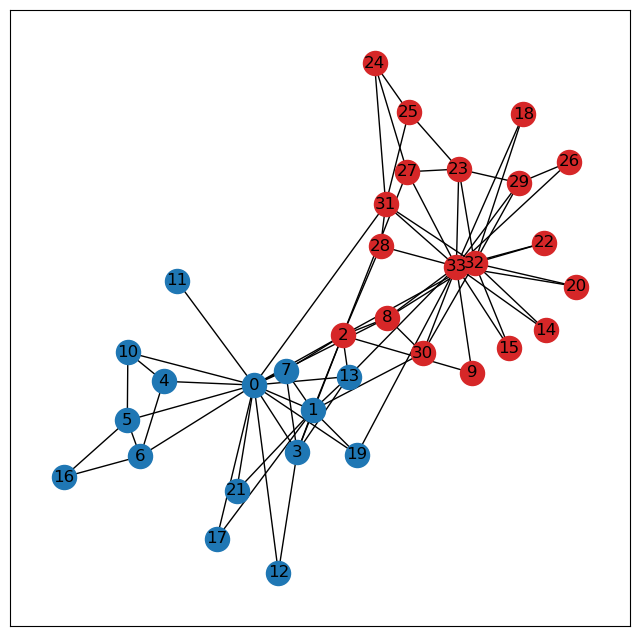

In [6]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_karate, seed =123)
nx.draw_networkx_nodes(g_karate, pos=pos, nodelist=list(gn_communities[0][0]), node_color="tab:blue")
nx.draw_networkx_nodes(g_karate, pos=pos, nodelist=list(gn_communities[0][1]), node_color="tab:red")
nx.draw_networkx_labels(g_karate, pos=pos)
nx.draw_networkx_edges(g_karate, pos=pos)

Now we plot the division that we obtain if we allow the algorithm to go through 3 iterations, removing sufficient edges to have 4 distinct connected components.

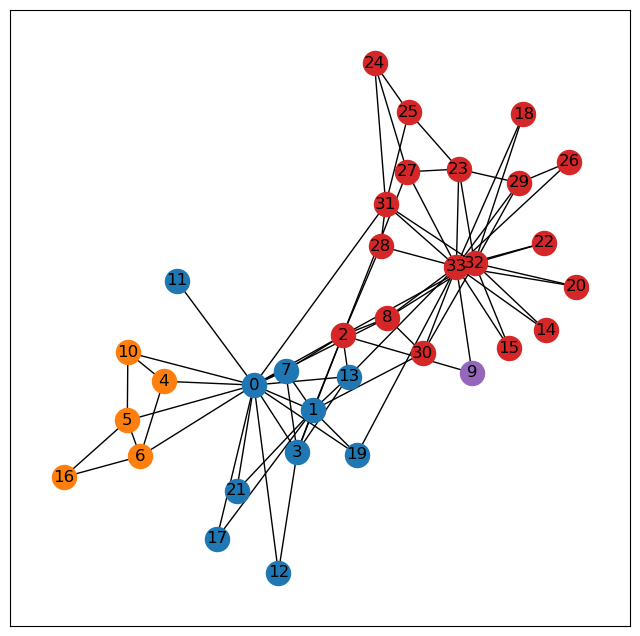

In [7]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_karate, seed =123)
nx.draw_networkx_nodes(g_karate, pos=pos, nodelist=list(gn_communities[2][0]), node_color="tab:blue")
nx.draw_networkx_nodes(g_karate, pos=pos, nodelist=list(gn_communities[2][1]), node_color="tab:red")
nx.draw_networkx_nodes(g_karate, pos=pos, nodelist=list(gn_communities[2][2]), node_color="tab:orange")
nx.draw_networkx_nodes(g_karate, pos=pos, nodelist=list(gn_communities[2][3]), node_color="tab:purple")
nx.draw_networkx_labels(g_karate, pos=pos)
nx.draw_networkx_edges(g_karate, pos=pos)

### Application

Now lets apply the Grivan-Newman algorithm to the drone laws dataset. Here we can note a potential drawback of the Girvan-Newman method. This method requires us to know how many communities we want to find in the data, as this will be our stopping point for the progressive removal of high traffic edges. Here we will first present a division of the dataset into 3 communities...

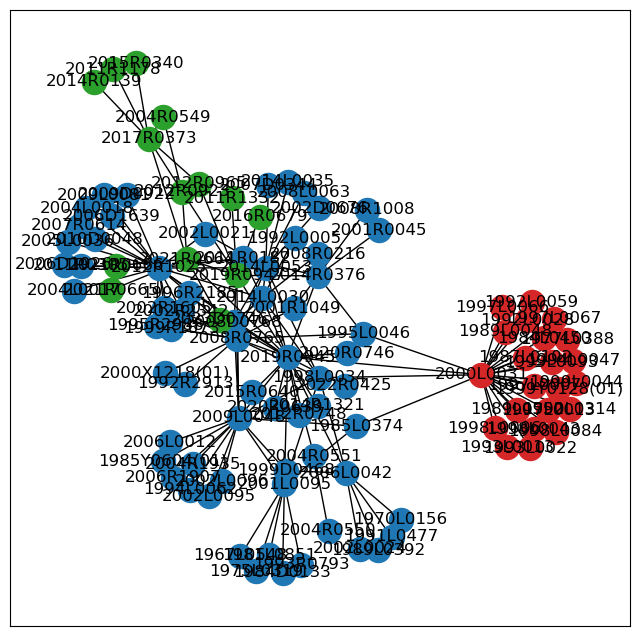

In [17]:
g_drones = load_graph_from_json("data/drone_laws/g_dronelaws_2.json")
g_drones = nx.to_undirected(g_drones)
gn_iterator = nx.algorithms.community.girvan_newman(g_drones)
gn_communities = []
for i in range(0,4):
    temp = next(gn_iterator)
    gn_communities.append(temp)

plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_drones, seed =123)
nx.draw_networkx_nodes(g_drones, pos=pos, nodelist=list(gn_communities[1][0]), node_color="tab:blue")
nx.draw_networkx_nodes(g_drones, pos=pos, nodelist=list(gn_communities[1][1]), node_color="tab:red")
nx.draw_networkx_nodes(g_drones, pos=pos, nodelist=list(gn_communities[1][2]), node_color="tab:green")
nx.draw_networkx_labels(g_drones, pos=pos)
nx.draw_networkx_edges(g_drones, pos=pos);

Note that very clear community appears to the right in red. However the "mainland" in blue appears too cluttered. Perhaps it is beneficial to stop the algorithm at a later stage. Results seem to improve when we ask the algorithm to produce 5 communities: 

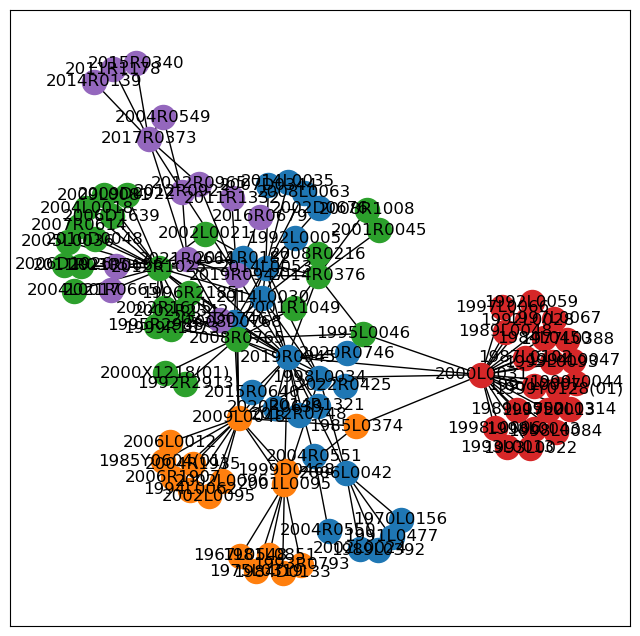

In [18]:
g_drones = load_graph_from_json("data/drone_laws/g_dronelaws_2.json")
g_drones = nx.to_undirected(g_drones)
gn_iterator = nx.algorithms.community.girvan_newman(g_drones)
gn_communities = []
for i in range(0,4):
    temp = next(gn_iterator)
    gn_communities.append(temp)

plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_drones, seed =123)
nx.draw_networkx_nodes(g_drones, pos=pos, nodelist=list(gn_communities[3][0]), node_color="tab:blue")
nx.draw_networkx_nodes(g_drones, pos=pos, nodelist=list(gn_communities[3][1]), node_color="tab:red")
nx.draw_networkx_nodes(g_drones, pos=pos, nodelist=list(gn_communities[3][2]), node_color="tab:green")
nx.draw_networkx_nodes(g_drones, pos=pos, nodelist=list(gn_communities[3][3]), node_color="tab:orange")
nx.draw_networkx_nodes(g_drones, pos=pos, nodelist=list(gn_communities[3][4]), node_color="tab:purple")
nx.draw_networkx_labels(g_drones, pos=pos)
nx.draw_networkx_edges(g_drones, pos=pos);

At any rate, the Girvan-Newman method requires support for determining the right stopping point, the right amount of communities in which to partition the network. This may be done through domain knowledge or through scores such as modularity or a combination of both, but it is outside the scope of this presentaion whose main purpose is to present the algorithm.

## 4.2. Label Propagation Communities

Label propagation algorithms can best be understood as a contagion process that passes on labels or categories instead of illnesses: A nearby node has a chance to 'infect' its neighbors passing on its label. As the process goes on, one can observe how labels spread accross a population of nodes, perhaps stabilizing in a certain configuration.

The idea of label propagation is most intuitive in semi-supervised learning. This is a scenario when one knows the labels of some nodes, but not of others, and a label infection process is simulated in order to see which nodes get infected with which labels. For example, consider a social network in which we know that some actors vote for the blue party, that some vote for the red party, but for the most part, we have no knoledge of the voting preferences of the actors. In this case, the actors for whom voting preferences are known are our labeled nodes and the ones for which we do not have information the unlabeled ones. We can try to estimate the voting preferences of unlabeled actors by allowing the 'votes blue' and 'votes red' label to spread to the nearby nodes, as if it were a virus, for a certain amount of time or until a certain condition is met. 

This type of problem is not the standard one of community detection because in this scenario we already know the classification of some nodes Label propagation communities is an application of label propagation where the setting is completely unsupervised. That is, we have no prior knowledge of the final categories or results that we want to achieve. So instead of having some nodes start of with a 'votes blue' label and a 'votes red' label or something to that effect, we start only with the positional information of the nodes and edges, and hope to identify meaningful groupings through the simulated contagion process. Because there are no initial labels, label propagation communities works slighlty different. It is necessary to first assume that every node has its own unique label. Then as labels spread to nearby nodes, some labels may start to dominate, giving us the desired result.

Label propagation communities can have significant elements of randomness. The exact outcome configuration may not be the same every time the algorithm runs. In some cases, label propagation communities may prove to be unstable as nodes trade labels back and forth endlessly. There are different versions of the algorithm which can minimize these problems. We will introduce the simplest version here. That being said, NetworkX does not use the simplest version. It uses a semi-synchronous version of label propagation communities introduced by Cordasco and Gargano (2011). This version will be explained further below.

We first simulate a very small toy network and give every node a color to represent that every node is given its own label.

In [6]:
g_small = nx.Graph()
g_small.add_nodes_from([1, 2, 3, 4, 5])
g_small.add_edges_from([(1, 2), (1, 3), (2,3), (3,4), (4,5)])


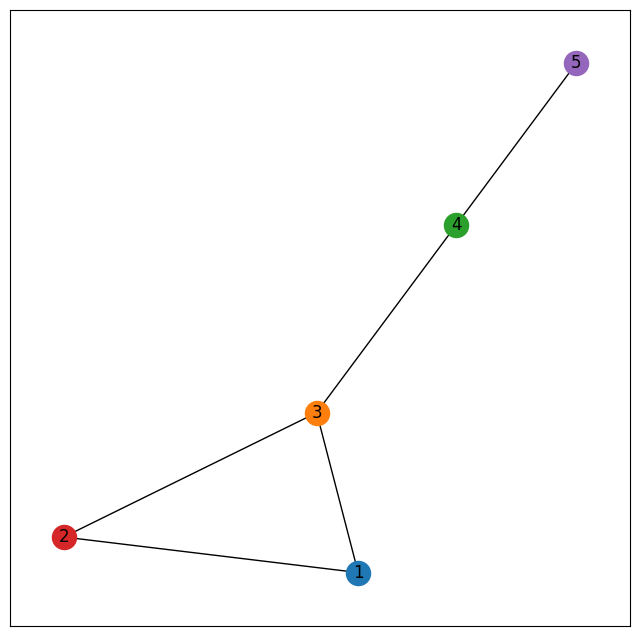

In [7]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_small, seed =123)
nx.draw_networkx_nodes(g_small, pos=pos, nodelist=[1], node_color="tab:blue")
nx.draw_networkx_nodes(g_small, pos=pos, nodelist=[2], node_color="tab:red")
nx.draw_networkx_nodes(g_small, pos=pos, nodelist=[3], node_color="tab:orange")
nx.draw_networkx_nodes(g_small, pos=pos, nodelist=[4], node_color="tab:green")
nx.draw_networkx_nodes(g_small, pos=pos, nodelist=[5], node_color="tab:purple")
nx.draw_networkx_labels(g_small, pos=pos)
nx.draw_networkx_edges(g_small, pos=pos)

### Label propagation communities

Label propagation communities essentially works by having nodes take the label that most commonly appears among their neighbors. This is formalized by the following expression (Cordasco and Gargano, 2011):

$$ l_v = \underset{l}{argmax} \sum_{u \in N(v)} [l_u == l] $$

Here, $l$ means label. Node $v$ is the node under consideration. $ u \in N(v) $ denotes the neighbors of $v$. The expression in brackets $[l_u == l]$ is the Iverson bracket, which gives a 1 if the condition is met and otherwise a 0. $argmax$ returns the maximum value of the distinct label counts. 

Put more simply, what this formula expresses is that the label of $v$ denoted by $ l_v $ will be whichever is the predominant label amongst neighboring nodes. Ties are broken randomly. 

Looking at our toy network above, because we have just started with every node having its own label, there will be no predominant labels in the first run of the algorithm: For node 1, the label red and orange are equally common, for node 4 the labels orange and purple are equally common, etc. At this stage ties have to be broken randomly.

Let us assume that label 1 propagates to node 2, and that label 5 propagates to node 4. To makes things easier, we assume that no further changes take place and stop the first run of the algorithm.

After one iteration the network will look like this:

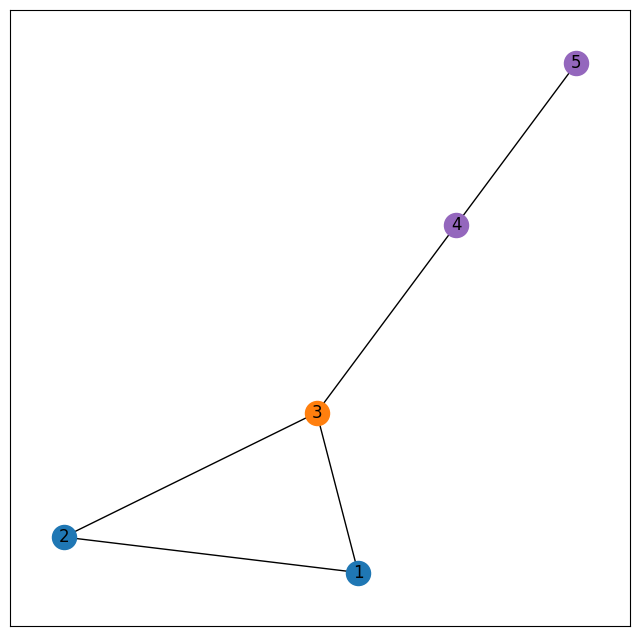

In [8]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_small, seed =123)
nx.draw_networkx_nodes(g_small, pos=pos, nodelist=[1], node_color="tab:blue")
nx.draw_networkx_nodes(g_small, pos=pos, nodelist=[2], node_color="tab:blue")
nx.draw_networkx_nodes(g_small, pos=pos, nodelist=[3], node_color="tab:orange")
nx.draw_networkx_nodes(g_small, pos=pos, nodelist=[4], node_color="tab:purple")
nx.draw_networkx_nodes(g_small, pos=pos, nodelist=[5], node_color="tab:purple")
nx.draw_networkx_labels(g_small, pos=pos)
nx.draw_networkx_edges(g_small, pos=pos)

In the second iteration the next step is clear: Node 3 will change label to blue. This will necessarily happen because there are two votes for blue, versus one for purple.

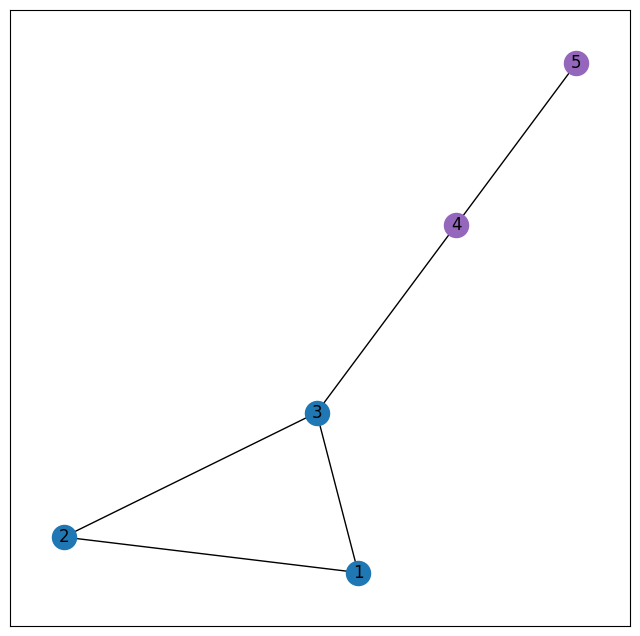

In [9]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_small, seed =123)
nx.draw_networkx_nodes(g_small, pos=pos, nodelist=[1], node_color="tab:blue")
nx.draw_networkx_nodes(g_small, pos=pos, nodelist=[2], node_color="tab:blue")
nx.draw_networkx_nodes(g_small, pos=pos, nodelist=[3], node_color="tab:blue")
nx.draw_networkx_nodes(g_small, pos=pos, nodelist=[4], node_color="tab:purple")
nx.draw_networkx_nodes(g_small, pos=pos, nodelist=[5], node_color="tab:purple")
nx.draw_networkx_labels(g_small, pos=pos)
nx.draw_networkx_edges(g_small, pos=pos)

We are going to stop our description here, but the algorithm might continue working until some stopping criterion is met, i.e., no further changes in the nodes affiliation.

Note that the path to get to the blue triangle was a random one. It could have happened that the label red or orange propagated instead. Such randomness is not problematic in this scenario. While the process that forms the triangle is random, the outcome here is deterministic. Nodes 1, 2, and 3 are bound to share a label by the second step of the algorithm when two nodes of the triangle will share the same label, forcing the third node to move to that community. Which labels gets shared (blue, red, or orange) is irrelevant, because the label here does not convey prior known information, but merely the fact that these three nodes form a community.

### Semi-synchronous label propagation and graph coloring

The version of the algorithm implemented in networkx is more complex than direct label propagation. Instead of propagating all the nodes at the same time, it propagates only a certain group of nodes and then the next. The groups here are not communities, but nodes that belong the same coloring. Graph coloring explores how many colors are needed to color a graph in such a way that no two adjacent vertices share the same color. We are actually familiar with the idea in the form of a political map, which is generally colored in such a way that no two adjacent political entities share the same color.

![image](images/ch4/Map_of_United_States_vivid_colors_shown.png)

Graph coloring in itself is outside the scope of this exposition. But it is good to know that there are algorithms that can provide colorings to networks. In our previous toy graph, only 3 colors are needed to satisfy the condition that no two neighboring nodes share a color, as can be seen below:


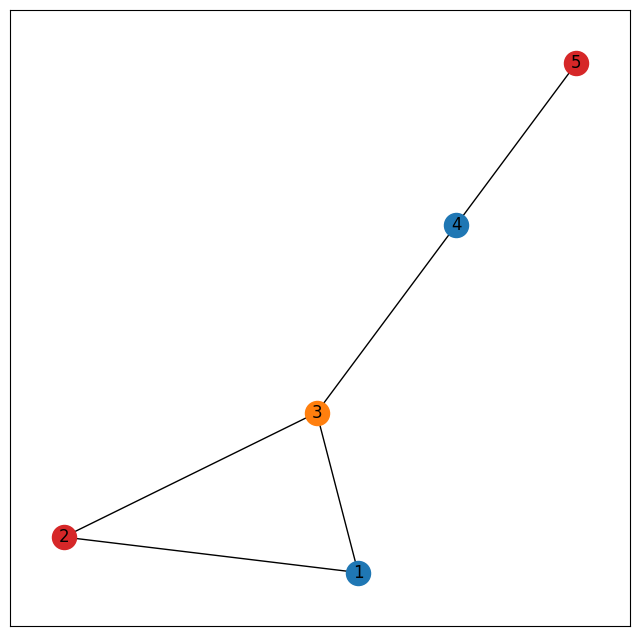

In [10]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_small, seed =123)
nx.draw_networkx_nodes(g_small, pos=pos, nodelist=[1], node_color="tab:blue")
nx.draw_networkx_nodes(g_small, pos=pos, nodelist=[2], node_color="tab:red")
nx.draw_networkx_nodes(g_small, pos=pos, nodelist=[3], node_color="tab:orange")
nx.draw_networkx_nodes(g_small, pos=pos, nodelist=[4], node_color="tab:blue")
nx.draw_networkx_nodes(g_small, pos=pos, nodelist=[5], node_color="tab:red")
nx.draw_networkx_labels(g_small, pos=pos)
nx.draw_networkx_edges(g_small, pos=pos)

>Note that graph colorings function in the opposite way to communities, isolating nodes instead of clustering them together.

What the semi-synchronous algorithm does, is that it carries out the process of label propagation synchronously within each of the colors, following a randomly chosen order. To give an example, it could be that here first only the blue nodes propagate, followed by the red nodes, and so on. This semi-synchronous approach can give more determinacy to propagation outcomes, reducing or eliminating cycles where nodes jump back and forth from one community to another. The reader can inspect visually that the semi-synchronous approach, starting with blue, will rapidly lead to all of the nodes of the aforementioned network falling within one community.

### Application

We implement the process in NetworkX. We will use the kite graph for an example, which is clustered in 2 communities, one for the body of the kite and one for the tail. NetworkX only gives us the final result so we cannot show the step-by-step propagation process.

In [11]:
g_kite = nx.krackhardt_kite_graph()
nx.algorithms.community.label_propagation_communities(g_kite)

dict_values([{0, 1, 2, 3, 4, 5, 6, 7}, {8, 9}])

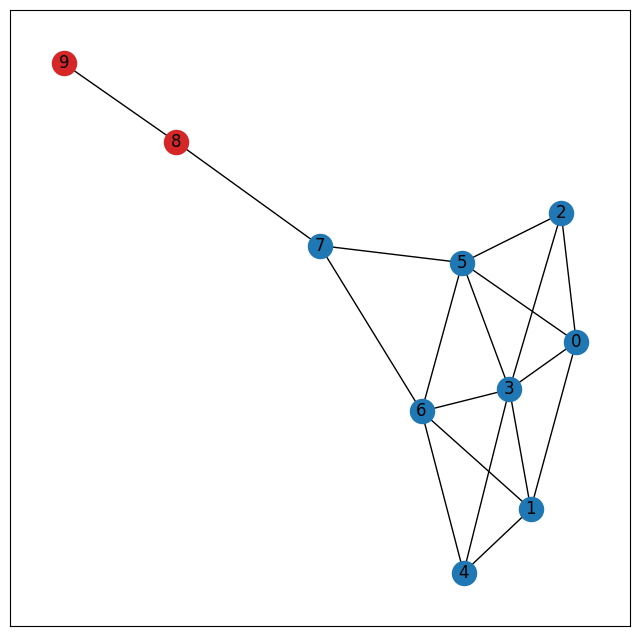

In [12]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_kite, seed =123)
nx.draw_networkx_nodes(g_kite, pos=pos, nodelist=[0, 1, 2, 3, 4, 5, 6, 7], node_color="tab:blue")
nx.draw_networkx_nodes(g_kite, pos=pos, nodelist=[8,9], node_color="tab:red")
nx.draw_networkx_labels(g_kite, pos=pos)
nx.draw_networkx_edges(g_kite, pos=pos)

Now lets apply the algorithm to the drones dataset. Here we can see that the propagation process becomes stable after having found 12 communities. Unlike with the Girvan-Newman algorithm, there is no need to specify the 

In [23]:
results = list(nx.algorithms.community.label_propagation_communities(g_drones))
len(results)

12

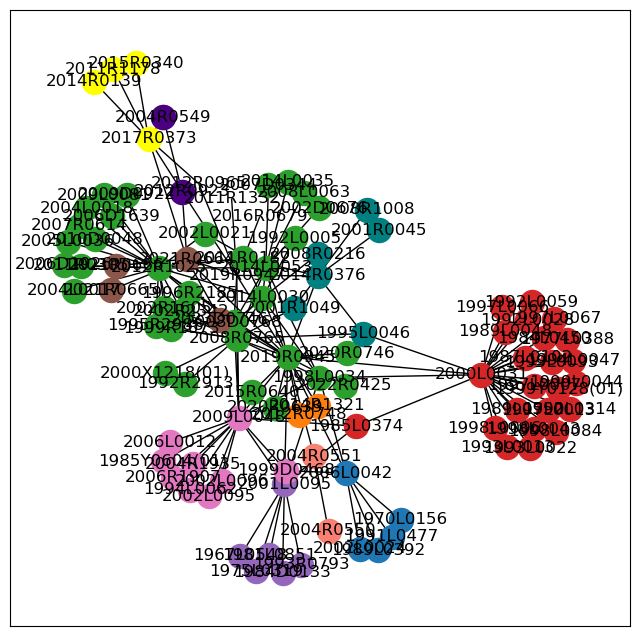

In [32]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_drones, seed =123)
nx.draw_networkx_nodes(g_drones, pos=pos, nodelist=list(results[0]), node_color="tab:blue")
nx.draw_networkx_nodes(g_drones, pos=pos, nodelist=list(results[1]), node_color="tab:red")
nx.draw_networkx_nodes(g_drones, pos=pos, nodelist=list(results[2]), node_color="tab:green")
nx.draw_networkx_nodes(g_drones, pos=pos, nodelist=list(results[3]), node_color="tab:orange")
nx.draw_networkx_nodes(g_drones, pos=pos, nodelist=list(results[4]), node_color="tab:purple")
nx.draw_networkx_nodes(g_drones, pos=pos, nodelist=list(results[5]), node_color="tab:pink")
nx.draw_networkx_nodes(g_drones, pos=pos, nodelist=list(results[6]), node_color="tab:brown")
nx.draw_networkx_nodes(g_drones, pos=pos, nodelist=list(results[7]), node_color="teal")
nx.draw_networkx_nodes(g_drones, pos=pos, nodelist=list(results[8]), node_color="salmon")
nx.draw_networkx_nodes(g_drones, pos=pos, nodelist=list(results[9]), node_color="yellow")
nx.draw_networkx_nodes(g_drones, pos=pos, nodelist=list(results[10]), node_color="gray")
nx.draw_networkx_nodes(g_drones, pos=pos, nodelist=list(results[10]), node_color="indigo")
nx.draw_networkx_labels(g_drones, pos=pos)
nx.draw_networkx_edges(g_drones, pos=pos);

## 4.3 Louvain Communities

The Louvain method for community detection (Blondel, Lambiotte & Lefebvre 2008) is an algorithm that finds communities by using the concept of modularity gain. To fully introduce this method, we first have to understand the concept of modularity.

### Modularity

Modularity, in essence, compares the edges of nodes to other nodes within a proposed community to the edges that these nodes could be expected to have if they were randomly connected to other nodes within or outside the community. For example, it may be the case that court decisions on contract law are more likely to cite one another (edges to nodes within the community) than to cite random court decisions. The higher the number of edges within the community relative to what would be expected in a random assignment, the higher the community's modularity.


The formula for modularity can be presented in a variety of ways and there are advantages to each form or presentation. Here are two versions:

$$ Q = \frac{1}{2m}\sum_{c=1}^{n} \left[ \Sigma A_c - \gamma\frac{\Sigma D_c^2}{2m} \right] $$


$$ Q = \sum_{c=1}^{n} \left[ \frac{\Sigma A_c}{2m} - \gamma \frac{\Sigma D_c^2}{2m^2}\right] $$


We will focus on the second formula in our discussion. Here, the $ \frac{1}{2m}$ has been multiplied accross the expression. This representation provides the most insight into what modularity measures:

* $ \frac{\Sigma A_c}{2m} $ represents the proportion of purely intra-community edges for a given community to the total number of edges ($m$). 
>The 2 in the denominator accounts for the fact that every edge has 2 nodes. Remember here that the adjacency matrix ($A$) simply records the connection that may exist between two nodes. Adding these up will result in a measure of how well connected a community is within itself.

* $ \frac{\Sigma D_c^2}{2m^2} $ represents the expected number of edges that would exist from the inter-community nodes to nodes within or outside the community if these were connected at random. 
>Note that here the degree matrix is used, and not the adjacency matrix. The degree matrix only records the importance of the nodes, but not who they are connected to. Using this as a basis, it is possible to have a view of where the edges would fall if they were assigned randomly.  

* $\gamma$ is a dampening parameter, that for our purposes can be ignored if set to 1. 
>Making this number smaller than 1 will make it easier to find communities, and making it larger than 1 makes communities harder to find.

* The $ \Sigma $ is a summation notation that states that the difference between ratios will be repeated for every hypothesized community and added up. The higher the ultimate summation, the better the community partition is.

The key to this formula is understanding that we have a difference (a subtraction) between two ratios representing the inter-community edges on the one side, and the edges that would occur if the nodes within the community were to be assigned partners randomly, within or outside of the community. If the proportion of inter-community edges is greter than random, we will have positive number which is considered indicative of a community being present.

We can operationalize the formula 'by hand' on the graph of Florentine families hypothesizing that the families Castellani, Peruzzi and Strozzi form a community vis-a-vis the rest of the other families. A quick look at the graphs suggest that this is a reasonable grouping.

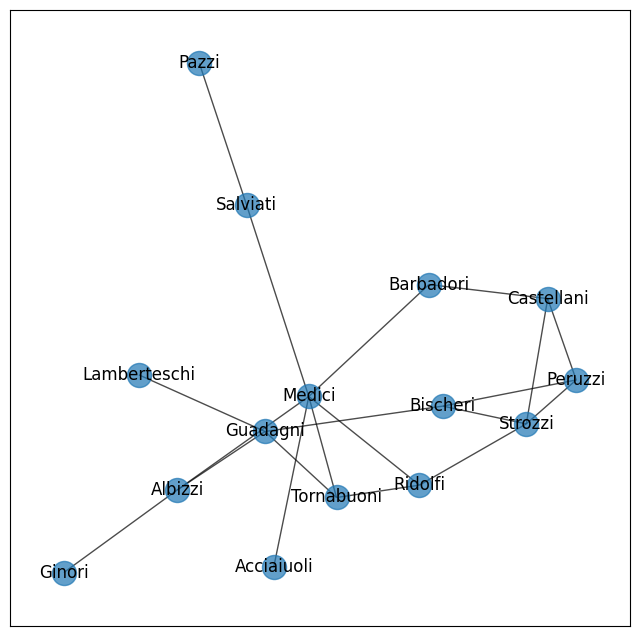

In [22]:
g_florentine = nx.florentine_families_graph()
draw_spring(g_florentine)

We first save two lists with the names of the nodes that we want to use as hypothesized communities. Castellani, Peruzzi and Strozzi in one list, the rest on the other.

In [23]:
fl_CPS = ['Castellani','Peruzzi','Strozzi']
fl_other= ['Acciaiuoli', 'Medici', 'Barbadori', 'Ridolfi', 'Tornabuoni', 'Albizzi', 'Salviati', 'Pazzi', 'Bischeri', 'Guadagni', 'Ginori', 'Lamberteschi']

Since $m$ is just the number of edges we can obtain the number in this manner.

In [24]:
m = len(g_florentine.edges)
m

20

For $\Sigma A_c $ we need to get the adjacency matrix of just the nodes within the community. This means we need to sever the connection of the community with other nodes. We can get this with the subgraph function.

In [25]:
sub_fl_CPS = g_florentine.subgraph(fl_CPS)
sub_fl_other = g_florentine.subgraph(fl_other)

Now we can get the adjacency matrix of the subgraphs:

In [26]:
nx.adjacency_matrix(sub_fl_CPS).todense()

array([[0, 1, 1],
       [1, 0, 1],
       [1, 1, 0]])

Numpy can sum all the values of such matrices with a call to np.sum.

In [27]:
SA_cps = np.sum(nx.adjacency_matrix(sub_fl_CPS).todense())
SA_other = np.sum(nx.adjacency_matrix(sub_fl_other).todense())
print(f"the value of SigmaA_c for the CPS community is {SA_cps} and for the other is {SA_other}")

the value of SigmaA_c for the CPS community is 6 and for the other is 26


This provides us with the information we need for the left hand side of the difference.

Now we move to work on the right side of the difference. The value of $ \Sigma D_c $ is the sum of the degree of the nodes that interest us, but not with their values cut off from the network - that is, not as subgraphs - but in their full values connected to the Florentine families network. 

In terms of code it can be slightly tricky to unpack these values. Below we use a np.sum over a list comprehension that produces the degree scores of only the nodes we need.

In [28]:
SD_cps = np.sum([x[1] for x in list(nx.degree(g_florentine, fl_CPS))])

SD_other = np.sum([x[1] for x in list(nx.degree(g_florentine, fl_other))])

print(f"the value of SigmaD_c for the CPS community is {SD_cps} and for the other is {SD_other}")

the value of SigmaD_c for the CPS community is 10 and for the other is 30


Now we are ready to fill in the blanks. Remember the formula is:

$$ Q = \sum_{c=1}^{n} \left[ \frac{\Sigma A_c}{2m} - \gamma\left( \frac{\Sigma D_c}{2m} \right) ^2 \right] $$

So for the first community we have

$$ CPS =\left[ \frac{6}{40} - \gamma\left( \frac{10}{40} \right) ^2 \right] = 0.875 $$

In [29]:
CPS_result = (SA_cps/(2*m)) - (SD_cps**2/(2*m)**2)
CPS_result

0.0875

And for the second 

$$ other = \left[ \frac{26}{40} - \gamma\left( \frac{30}{40} \right) ^2 \right] = 0.875 $$

In [30]:
other_result = (SA_other/(2*m)) - ((SD_other**2/(2*m)**2))
other_result

0.08750000000000002

And adding them together we get 0.175

In [31]:
CPS_result + other_result

0.17500000000000002

 Which is the same as the official result.

In [32]:
nx.algorithms.community.modularity(g_florentine, [fl_CPS, fl_other])

0.17500000000000002

Thus the following partition has the positive modularity score of 0.175.

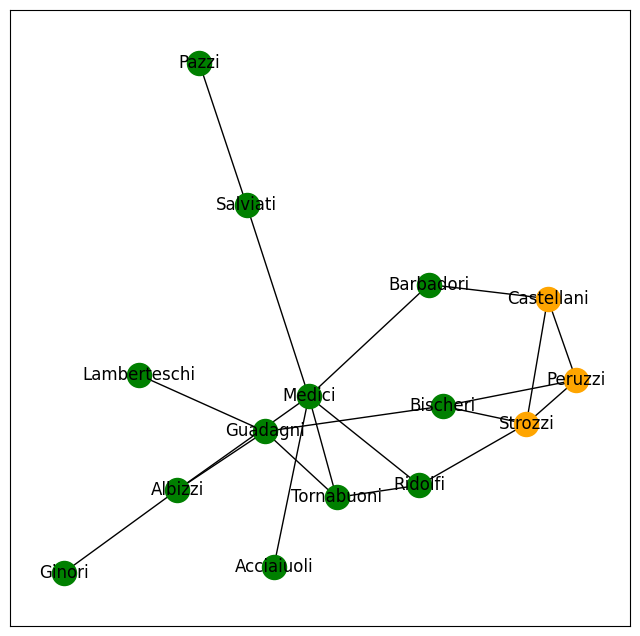

In [33]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_florentine)
nx.draw_networkx_nodes(g_florentine, pos, nodelist=fl_CPS, node_color='orange')
nx.draw_networkx_nodes(g_florentine, pos, nodelist=fl_other, node_color='green')
nx.draw_networkx_edges(g_florentine, pos=pos)
nx.draw_networkx_labels(g_florentine, pos=pos);

### The Louvain Communities Algorithm

The Louvain community detection aims to find the distribution of communities that will give the highest modularity score, using a cumulative random search:

1. It will asume every node is a community and score the modularity.
2. It will assign every node to a community with one of its neighbors and score the modularity of the result.
3. It will keep the assignment that gives the highest modularity score.
4. The resulting communities will be treated as nodes.
5. Step 1 is repeated.

This process keeps going until there is no more modularity gain.

We can quickly try to run the Louvain communities algorithm to find the best partition of the Florentine families network that we used earlier to discuss modularity.
It turns out the best split is in four communities. Compared to our intuitive results presented above, we can see that Castellani, Peruzzi and Strozzi did deserve to go together, but that Bischeri should have been also part their team.

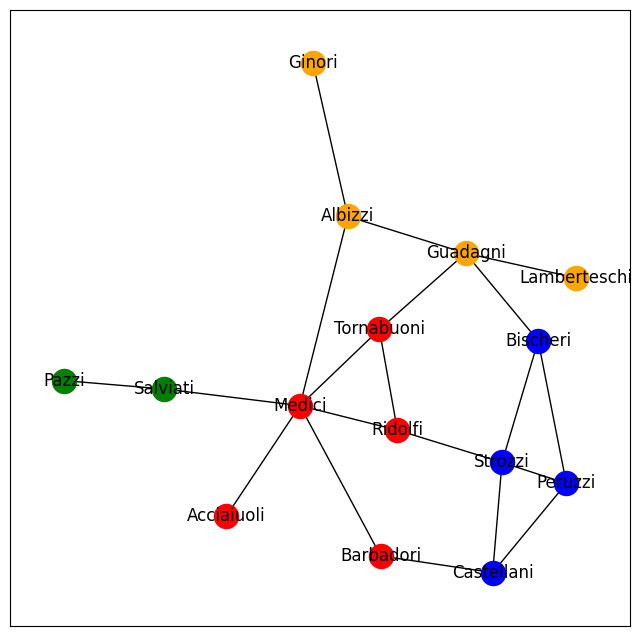

In [34]:
plt.figure(figsize=(8,8))
result = nx.algorithms.community.louvain_communities(g_florentine)
pos = nx.spring_layout(g_florentine)
nx.draw_networkx_nodes(g_florentine, pos, nodelist=result[0], node_color='blue')
nx.draw_networkx_nodes(g_florentine, pos, nodelist=result[1], node_color='red')
nx.draw_networkx_nodes(g_florentine, pos, nodelist=result[2], node_color='green')
nx.draw_networkx_nodes(g_florentine, pos, nodelist=result[3], node_color='orange')
nx.draw_networkx_edges(g_florentine, pos=pos)
nx.draw_networkx_labels(g_florentine, pos=pos);

When calculating the modularity score for the Louvain-detected communities, we can observe that at 0.3975 it is quite higher than our initial partition.

In [36]:
nx.algorithms.community.modularity(g_florentine, result)

0.3975

We now try to approximate this by hand. Let us see how far we can get. We will use a smaller graph, the kite, to make our life easier. There are key differences between what we are doing and the actual Louvain Communities algorithm. However, this will be enough for us to get an idea of what is going on.

The question is how to best partition the kite in terms of modularity.

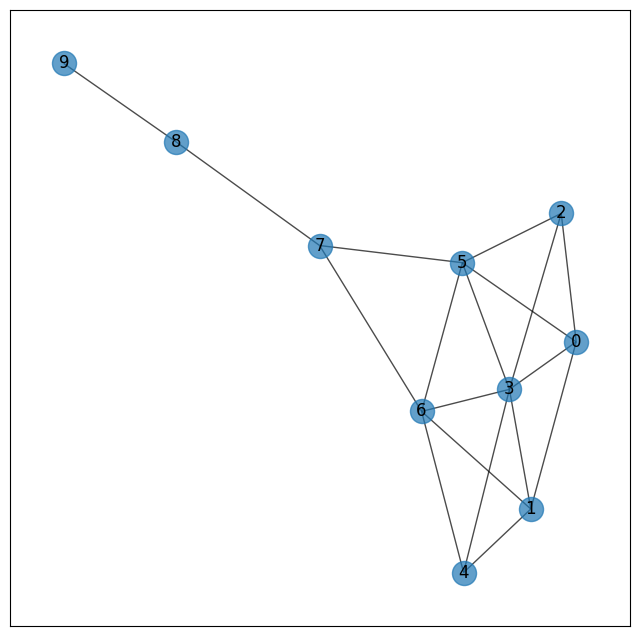

In [37]:
g_kite = nx.krackhardt_kite_graph()
draw_spring(g_kite)

Doing a pseudo-Louvain process, We begin by assigning each node in the kite graph to its own community. Since this is a very bad partition, it makes sense that we get a negative modularity score.

In [38]:
nx.algorithms.community.modularity(g_kite, [[x] for x in range(0,10)])

-0.11574074074074076

Now we will assign each node, to one of its neighbors, and obtain the modularity score.

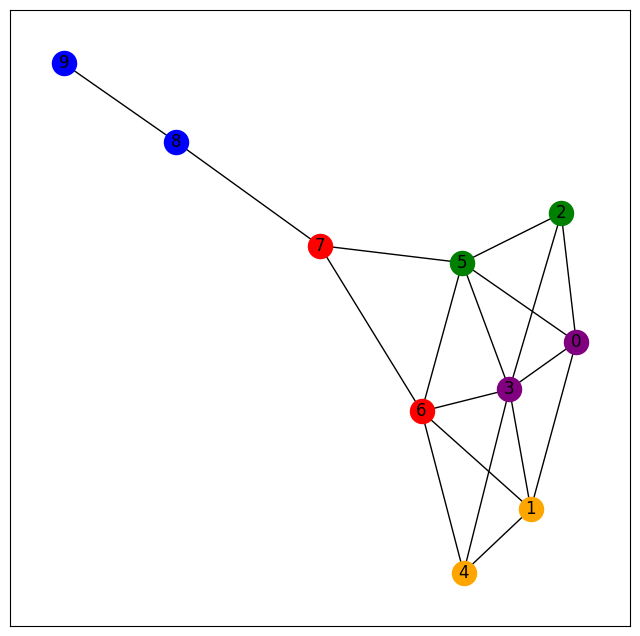

In [39]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_kite, seed=123)
nx.draw_networkx_nodes(g_kite, pos, nodelist=[9,8], node_color='blue')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[7,6], node_color='red')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[5,2], node_color='green')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[4,1], node_color='orange')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[3,0], node_color='purple')
nx.draw_networkx_edges(g_kite, pos=pos)
nx.draw_networkx_labels(g_kite, pos=pos);

In [40]:
nx.algorithms.community.modularity(g_kite, [[9,8], [7,6], [5,2],[4,1],[3,0]])

0.057098765432098755

We could keep assigning nodes and see an increase.

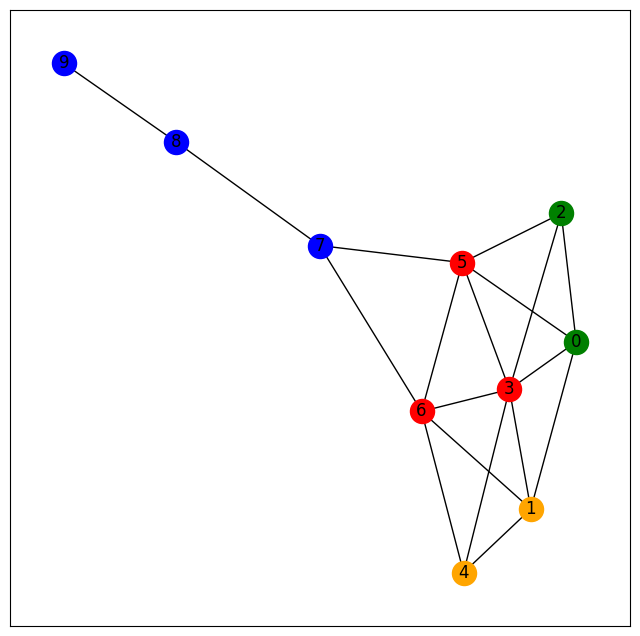

In [41]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_kite, seed=123)
nx.draw_networkx_nodes(g_kite, pos, nodelist=[9,8,7], node_color='blue')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[6,5,3], node_color='red')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[2,0], node_color='green')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[4,1], node_color='orange')
nx.draw_networkx_edges(g_kite, pos=pos)
nx.draw_networkx_labels(g_kite, pos=pos);

In [42]:
nx.algorithms.community.modularity(g_kite, [[9,8,7], [6,5,3], [2,0],[4,1]])

0.08796296296296295

But not every reassignment is going to be an increase. If we extend the first cluster, we will get a decrease in modularity.

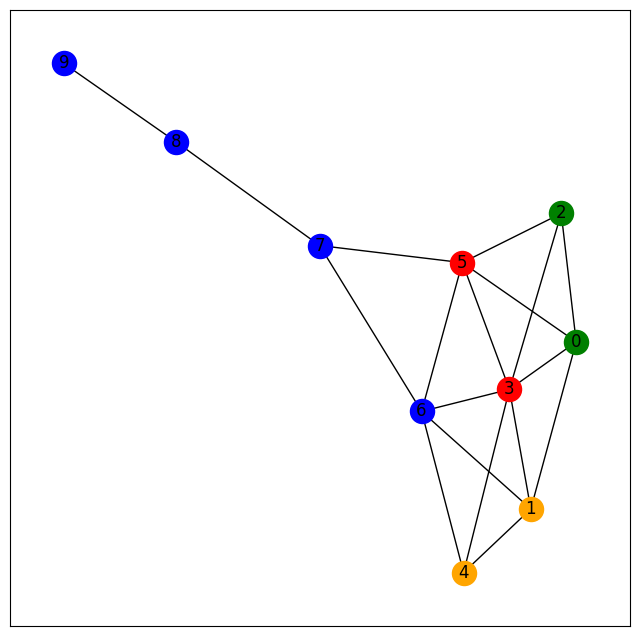

In [43]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_kite, seed=123)
nx.draw_networkx_nodes(g_kite, pos, nodelist=[9,8,7, 6], node_color='blue')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[5,3], node_color='red')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[2,0], node_color='green')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[4,1], node_color='orange')
nx.draw_networkx_edges(g_kite, pos=pos)
nx.draw_networkx_labels(g_kite, pos=pos);

In [44]:
nx.algorithms.community.modularity(g_kite, [[9,8,7, 6], [5,3], [2,0],[4,1]])

0.07098765432098764

Our pseudo-Louvain algorithm would therefore stop short of that last assignment. The real Louvain method would do this in an mechanical, incremental fashion until the communities with very good modularity scores are found. The algorithm has elements of randomness, so it is not guaranteed to achieve the best result, or the same result every time it is run.

A difference of note is that instead of incrementally linking up the nodes of the kite, what are the communities at the first level will be turned into nodes at the second level. (!!add photo from louvain to leuven article!!). 

Also note that, unlike what we are doing, the real Louvain algorithm does not focus on modularity per se, but on modularity gain. That is, it focuses on the difference in modularity between one partitioning and another. It does not really look for the highest modularity value, but instead keeps going while it finds positive modularity gain, or until modularity gains are so small that they fall below a specified margin.

The formula for modularity gain is not so different from that of modularity:

$$ \Delta Q = \left[ \frac{\Sigma A_c + K_{in}}{2m} - \left(\frac{\Sigma D_c + K_{in}}{2m} \right)^2\right] - \left[\frac{\Sigma A_c}{2m}-\left(\frac{\Sigma D_c}{2m}\right)^2 - \left(\frac{K_{in}}{2m}\right)^2  \right]   $$

This can be seen as the difference of two modulary scores. One (the left brackets) is the score with the node $K$ inserted into it and the the other (the right bracket) is the score with the node $K$ removed from it. It is added on the left and removed on the right to represent the delta, or the difference in modularity, when one community gains a node and another one loses it.

With our pseudo-Louvain approach we did not did do the best possible combination, but with the real Louvain communities algorithm we can see what the better partition would be:

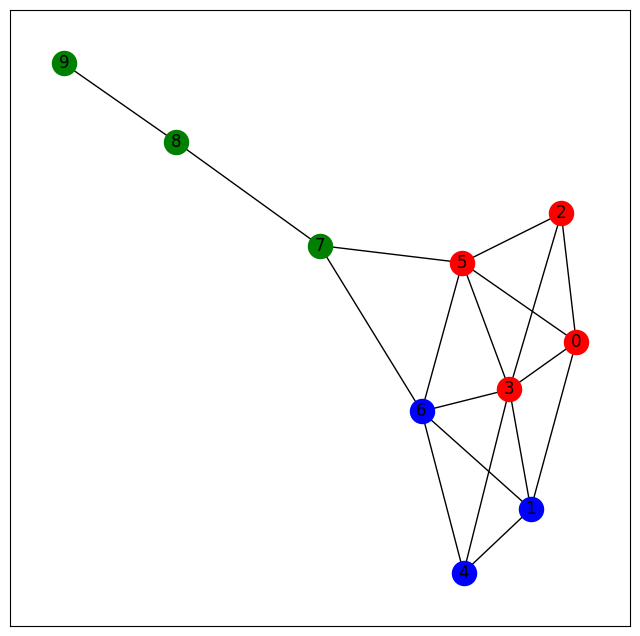

In [45]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_kite, seed=123)
result = nx.algorithms.community.louvain_communities(g_kite)
nx.draw_networkx_nodes(g_kite, pos, nodelist=result[0], node_color='blue')
nx.draw_networkx_nodes(g_kite, pos, nodelist=result[1], node_color='red')
nx.draw_networkx_nodes(g_kite, pos, nodelist=result[2], node_color='green')
nx.draw_networkx_edges(g_kite, pos=pos)
nx.draw_networkx_labels(g_kite, pos=pos);

### Application

Finally lets apply the Louvain algorithm to the drones dataset. In this case, the algorithm stops in identifying 6 communities.

In [37]:
results = nx.algorithms.community.louvain_communities(g_drones)


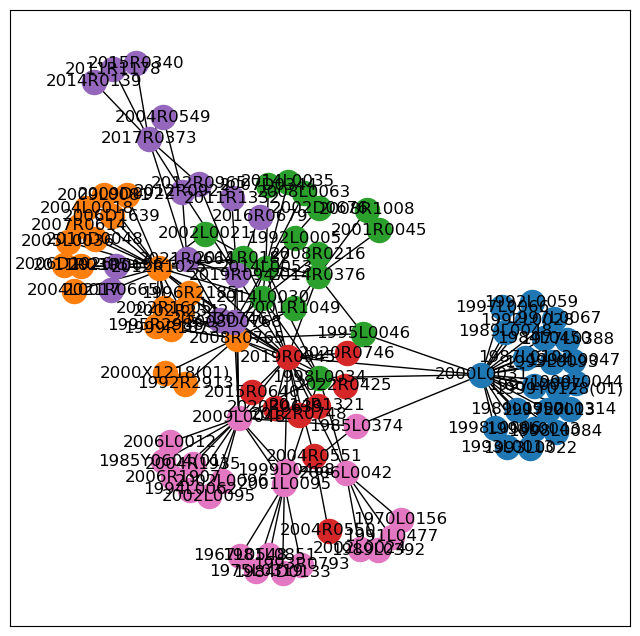

In [39]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_drones, seed =123)
nx.draw_networkx_nodes(g_drones, pos=pos, nodelist=list(results[0]), node_color="tab:blue")
nx.draw_networkx_nodes(g_drones, pos=pos, nodelist=list(results[1]), node_color="tab:red")
nx.draw_networkx_nodes(g_drones, pos=pos, nodelist=list(results[2]), node_color="tab:green")
nx.draw_networkx_nodes(g_drones, pos=pos, nodelist=list(results[3]), node_color="tab:orange")
nx.draw_networkx_nodes(g_drones, pos=pos, nodelist=list(results[4]), node_color="tab:purple")
nx.draw_networkx_nodes(g_drones, pos=pos, nodelist=list(results[5]), node_color="tab:pink")
nx.draw_networkx_labels(g_drones, pos=pos)
nx.draw_networkx_edges(g_drones, pos=pos);